In [2]:
import tsflex
print(tsflex.__version__)

0.2.3


## Get the data

In [3]:
from tsflex.utils.data import load_empatica_data

df_tmp, df_acc, df_gsr, df_ibi = load_empatica_data(["tmp", "acc", "gsr", "ibi"])

In [4]:
from pandas.tseries.frequencies import to_offset

data = [df_tmp, df_acc, df_gsr, df_ibi]
for df in data:
    print("Time-series:", df.columns.values)
    print(df.shape)
    try:
        print("Sampling rate:", 1 / pd.to_timedelta(to_offset(pd.infer_freq(df.index))).total_seconds(), "Hz")
    except:
        print("Irregular sampling rate")
    print()

Time-series: ['TMP']
(30200, 1)
Irregular sampling rate

Time-series: ['ACC_x' 'ACC_y' 'ACC_z']
(241620, 3)
Irregular sampling rate

Time-series: ['EDA']
(30204, 1)
Irregular sampling rate

Time-series: ['IBI']
(1230, 1)
Irregular sampling rate



## Look at the data

In [5]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(
    rows=len(data), cols=1, shared_xaxes=True, 
    subplot_titles=[df.columns.values[0].split('_')[0] for df in data],
    vertical_spacing=0.1,
)

for plot_idx, df in enumerate(data, 1):
    # Select first minute of data
    sub_df = df.first('1min')
    for col in df.columns:
        fig.add_trace(
            go.Scattergl(x=sub_df.index, y=sub_df[col].values, name=col, mode='markers'),
            row=plot_idx, col=1
        )

fig.update_layout(height=len(data)*200)

fig.show(renderer='iframe')

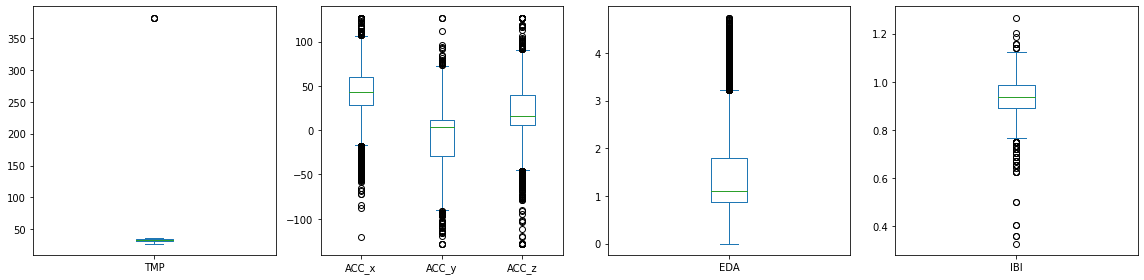

In [6]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16,4))

for plot_idx, df in enumerate(data):
    df.plot(kind='box', ax=axes[plot_idx])
plt.tight_layout()

These visualizations indicate that some preprocessing might be necessary for the signals (some sort of clipping)

# tsflex processing

This is roughly identical to the processing of [this paper notebook](https://github.com/predict-idlab/tsflex/blob/main/examples/tsflex_paper.ipynb)

In [7]:
import pandas as pd; import numpy as np; from scipy.signal import savgol_filter
from tsflex.processing import SeriesProcessor, SeriesPipeline

# Create the processing functions
def clip_data(sig: pd.Series, min_val=None, max_val=None) -> np.ndarray:
    return np.clip(sig,  a_min=min_val, a_max=max_val)

def smv(*sigs) -> pd.Series:
    sig_prefixes = set(sig.name.split('_')[0] for sig in sigs)
    result = np.sqrt(np.sum([np.square(sig) for sig in sigs], axis=0))
    return pd.Series(result, index=sigs[0].index, name='|'.join(sig_prefixes)+'_'+'SMV')

# Create the series processors (with their keyword arguments)
tmp_clippper = SeriesProcessor(clip_data, series_names="TMP", max_val=35)
acc_savgol = SeriesProcessor(
    savgol_filter, ["ACC_x", "ACC_y", "ACC_z"], window_length=33, polyorder=2
)
acc_smv = SeriesProcessor(smv, ("ACC_x", "ACC_y", "ACC_z"))

# Create the series pipeline & process the data
series_pipe = SeriesPipeline([tmp_clippper, acc_savgol, acc_smv])
series_pipe

[
	clip_data {'max_val': 35} :  ('TMP',)
	savgol_filter {'window_length': 33, 'polyorder': 2} :  ('ACC_x',) ('ACC_y',) ('ACC_z',)
	smv {} :  ('ACC_x', 'ACC_y', 'ACC_z')
]

In [8]:
out_data = series_pipe.process(data, drop_keys=["ACC_x", "ACC_y", "ACC_z"])

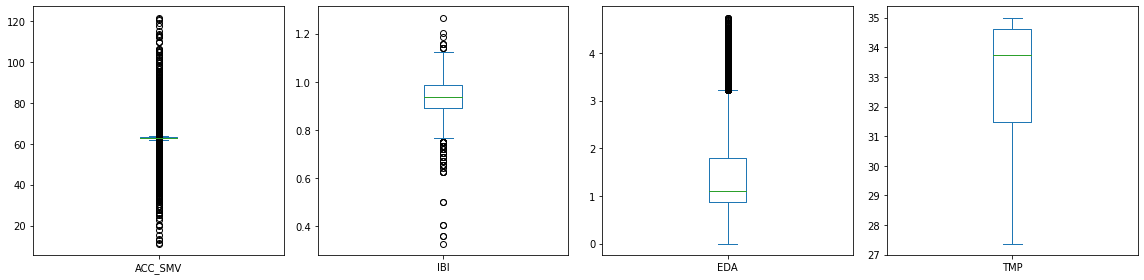

In [9]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16,4))

for plot_idx, df in enumerate(out_data):
    df.plot(kind='box', ax=axes[plot_idx])
plt.tight_layout()

# tsflex feature extraction with [tsfel](https://github.com/fraunhoferportugal/tsfel) integration

In [10]:
# !pip install tsfel

> Useful links;  
> [List of all tsfel features](https://tsfel.readthedocs.io/en/latest/descriptions/feature_list.html)  
> [More detailed documentation of the tsfel features](https://tsfel.readthedocs.io/en/latest/descriptions/modules/tsfel.feature_extraction.html#module-tsfel.feature_extraction.features)  
> [More detailed documentation of the tsfel feature dictionaries](https://tsfel.readthedocs.io/en/latest/descriptions/get_started.html#set-up-the-feature-extraction-config-file)

As [tsfel feature-functions](https://github.com/dmbee/seglearn/blob/master/seglearn/feature_functions.py) oftern requires `fs` (the sampling frequency), it is not advised to use these on irregular sampled data!  
Of course features that retun more than 1 value or require some keyword arguments should be wrapped in a `FuncWrapper`!

tsfel represents [a collection of features as a dictionary](https://github.com/fraunhoferportugal/tsfel/blob/master/tsfel/feature_extraction/features_settings.py).  
**=> requires wrapping this dictionary in `tsfel_feature_dict_wrapper` for interoperability with tsflex**

For individual functions, we differentiate two sets of tsfel features;
* *basic features*; functions that require no additional arguments (thus no `fs`) and return 1 value.  
  **=> integrates natively with tsflex**
* *advanced features*; features that require some keyword arguments (e.g., `fs`) and/or return multiple outputs.  
  **=> requires wrapping the function with its arguments and/or output names in a `FuncWrapper`**

In [11]:
# This wrapper handles tsfel its feature extraction settings
from tsflex.features.integrations import tsfel_feature_dict_wrapper

In [12]:
from tsflex.features import FeatureCollection, MultipleFeatureDescriptors

## Using tsfel feature extraction settings (i.e., dictionaries)

In [13]:
# Import some functions that return preset feature extraction setting from tsfel
from tsfel.feature_extraction import get_features_by_domain, get_features_by_tag

Calculate the features for a tsfel feature extraction dictionary.  
Note that;
* `tsfel_feature_dict_wrapper` transforms this feature extraction dictionary to a list of features that you can directly pass as the `function` argument of tsflex `MultipleFeatureDescriptors`.

In [14]:
simple_feats = MultipleFeatureDescriptors(
    functions=tsfel_feature_dict_wrapper(get_features_by_domain("temporal")),
    series_names=["ACC_SMV", "EDA", "TMP"],
    windows=["5min", "2.5min"],
    strides=["2.5min"],
)
feature_collection = FeatureCollection(simple_feats)
feature_collection

ACC_SMV: (
	win: 5m    , stride: 2m30s: [
		FeatureDescriptor - func: FuncWrapper(abs_energy, ['abs_energy'], {}),
		FeatureDescriptor - func: FuncWrapper(auc, ['auc'], {'fs': 100}),
		FeatureDescriptor - func: FuncWrapper(autocorr, ['autocorr'], {}),
		FeatureDescriptor - func: FuncWrapper(calc_centroid, ['calc_centroid'], {'fs': 100}),
		FeatureDescriptor - func: FuncWrapper(entropy, ['entropy'], {'prob': 'standard'}),
		FeatureDescriptor - func: FuncWrapper(mean_abs_diff, ['mean_abs_diff'], {}),
		FeatureDescriptor - func: FuncWrapper(mean_diff, ['mean_diff'], {}),
		FeatureDescriptor - func: FuncWrapper(median_abs_diff, ['median_abs_diff'], {}),
		FeatureDescriptor - func: FuncWrapper(median_diff, ['median_diff'], {}),
		FeatureDescriptor - func: FuncWrapper(negative_turning, ['negative_turning'], {}),
		FeatureDescriptor - func: FuncWrapper(neighbourhood_peaks, ['neighbourhood_peaks'], {'n': 10}),
		FeatureDescriptor - func: FuncWrapper(pk_pk_distance, ['pk_pk_distance'], {}),
		F

In [15]:
features_df = feature_collection.calculate(out_data, return_df=True, show_progress=True)
features_df

  0%|          | 0/108 [00:00<?, ?it/s]

,ACC_SMV__abs_energy__w=2m30s_s=2m30s,ACC_SMV__abs_energy__w=5m_s=2m30s,ACC_SMV__auc__w=2m30s_s=2m30s,ACC_SMV__auc__w=5m_s=2m30s,ACC_SMV__autocorr__w=2m30s_s=2m30s,ACC_SMV__autocorr__w=5m_s=2m30s,ACC_SMV__calc_centroid__w=2m30s_s=2m30s,ACC_SMV__calc_centroid__w=5m_s=2m30s,ACC_SMV__distance__w=2m30s_s=2m30s,ACC_SMV__distance__w=5m_s=2m30s,...,TMP__positive_turning__w=2m30s_s=2m30s,TMP__positive_turning__w=5m_s=2m30s,TMP__slope__w=2m30s_s=2m30s,TMP__slope__w=5m_s=2m30s,TMP__sum_abs_diff__w=2m30s_s=2m30s,TMP__sum_abs_diff__w=5m_s=2m30s,TMP__total_energy__w=2m30s_s=2m30s,TMP__total_energy__w=5m_s=2m30s,TMP__zero_cross__w=2m30s_s=2m30s,TMP__zero_cross__w=5m_s=2m30s
timestamp,,,,,,,,,,,,,,,,,,,,,
2017-06-13 14:24:43+02:00,1.908184e+07,NaN,3022.207008,NaN,1.908184e+07,NaN,23.906910,NaN,5213.615856,NaN,...,0,NaN,1.555662e-03,NaN,9.709995,NaN,77633.399416,NaN,0,NaN
2017-06-13 14:27:13+02:00,1.925024e+07,3.833208e+07,3035.056342,6057.889080,1.925024e+07,3.833208e+07,23.835228,47.976349,5467.746579,10682.362562,...,0,0.0,1.700201e-03,2.184900e-03,2.139997,11.869993,85725.292154,81611.222894,0,0.0
2017-06-13 14:29:43+02:00,1.900983e+07,3.826007e+07,3019.503928,6055.220254,1.900983e+07,3.826007e+07,23.992745,47.762682,4938.382681,10407.175836,...,0,0.0,2.860803e-04,1.477952e-03,2.160006,4.340004,91579.820534,88578.617598,0,0.0
2017-06-13 14:32:13+02:00,1.890783e+07,3.791766e+07,3010.422719,6030.555841,1.890783e+07,3.791766e+07,23.933202,47.898494,4986.299677,9925.683203,...,0,0.0,1.855356e-03,1.037513e-03,2.580021,4.760027,95357.710768,93390.804837,0,0.0
2017-06-13 14:34:43+02:00,1.884167e+07,3.774950e+07,3006.037084,6017.084596,1.884167e+07,3.774950e+07,24.062707,47.955778,4905.262402,9892.562917,...,0,0.0,2.051895e-03,2.330990e-03,2.880007,5.480026,104688.856427,99939.866555,0,0.0
2017-06-13 14:37:13+02:00,1.929179e+07,3.813345e+07,3026.586133,6033.251748,1.929179e+07,3.813345e+07,24.212030,48.421540,5928.286367,10834.549659,...,0,0.0,-1.873686e-04,8.588160e-04,2.910019,5.810026,107943.186561,106227.356130,0,0.0
2017-06-13 14:39:43+02:00,1.896016e+07,3.825194e+07,3013.262700,6040.484862,1.896016e+07,3.825194e+07,23.962277,47.880165,5290.050909,11219.419204,...,0,0.0,1.134469e-03,-1.163629e-04,2.399990,5.320007,106715.943239,107240.054212,0,0.0
2017-06-13 14:42:13+02:00,1.874805e+07,3.770820e+07,2998.938144,6012.826354,1.874805e+07,3.770820e+07,24.024076,47.858004,4844.241543,10135.292452,...,0,0.0,1.523723e-03,9.162737e-04,2.009964,4.439953,109795.294240,108165.325271,0,0.0
2017-06-13 14:44:43+02:00,1.911835e+07,3.786640e+07,3027.852560,6027.419770,1.911835e+07,3.786640e+07,24.078095,48.286049,4981.108909,9826.350453,...,0,0.0,-5.113351e-04,1.010799e-03,2.509998,4.519962,114531.573456,112069.891576,0,0.0


Extract some other tsfel features  
!! Make sure that you dont add tsfel feature dicts that contain the same feature (in that case tsflex will throw an error)

In [16]:
simple_feats = MultipleFeatureDescriptors(
    functions=(
        tsfel_feature_dict_wrapper(get_features_by_domain("statistical"))
        + tsfel_feature_dict_wrapper(get_features_by_tag("ecg"))
    ),
    series_names=["ACC_SMV", "EDA", "TMP"],
    windows=["5min", "2.5min"],
    strides=["2.5min"],
)
feature_collection = FeatureCollection(simple_feats)
feature_collection

ACC_SMV: (
	win: 5m    , stride: 2m30s: [
		FeatureDescriptor - func: FuncWrapper(ecdf, ['ecdf_1', 'ecdf_2', 'ecdf_3', 'ecdf_4', 'ecdf_5', 'ecdf_6', 'ecdf_7', 'ecdf_8', 'ecdf_9', 'ecdf_10'], {'d': 10}),
		FeatureDescriptor - func: FuncWrapper(ecdf_percentile, ['ecdf_percentile_percentile=v', 'ecdf_percentile_percentile=v'], {'percentile': '[0.2, 0.8]'}),
		FeatureDescriptor - func: FuncWrapper(ecdf_percentile_count, ['ecdf_percentile_count_percentile=v', 'ecdf_percentile_count_percentile=v'], {'percentile': '[0.2, 0.8]'}),
		FeatureDescriptor - func: FuncWrapper(hist, ['hist_1', 'hist_2', 'hist_3', 'hist_4', 'hist_5', 'hist_6', 'hist_7', 'hist_8', 'hist_9', 'hist_10'], {'nbins': 10, 'r': 1}),
		FeatureDescriptor - func: FuncWrapper(interq_range, ['interq_range'], {}),
		FeatureDescriptor - func: FuncWrapper(kurtosis, ['kurtosis'], {}),
		FeatureDescriptor - func: FuncWrapper(calc_max, ['calc_max'], {}),
		FeatureDescriptor - func: FuncWrapper(calc_mean, ['calc_mean'], {}),
		FeatureDes

In [17]:
features_df = feature_collection.calculate(out_data, return_df=True, show_progress=True)
features_df

  0%|          | 0/102 [00:00<?, ?it/s]

,ACC_SMV__calc_max__w=2m30s_s=2m30s,ACC_SMV__calc_max__w=5m_s=2m30s,ACC_SMV__calc_mean__w=2m30s_s=2m30s,ACC_SMV__calc_mean__w=5m_s=2m30s,ACC_SMV__calc_median__w=2m30s_s=2m30s,ACC_SMV__calc_median__w=5m_s=2m30s,ACC_SMV__calc_min__w=2m30s_s=2m30s,ACC_SMV__calc_min__w=5m_s=2m30s,ACC_SMV__calc_std__w=2m30s_s=2m30s,ACC_SMV__calc_std__w=5m_s=2m30s,...,TMP__mean_abs_deviation__w=2m30s_s=2m30s,TMP__mean_abs_deviation__w=5m_s=2m30s,TMP__median_abs_deviation__w=2m30s_s=2m30s,TMP__median_abs_deviation__w=5m_s=2m30s,TMP__rms__w=2m30s_s=2m30s,TMP__rms__w=5m_s=2m30s,TMP__skewness__w=2m30s_s=2m30s,TMP__skewness__w=5m_s=2m30s,TMP__wavelet_abs_mean_widths=v__w=2m30s_s=2m30s,TMP__wavelet_abs_mean_widths=v__w=5m_s=2m30s
timestamp,,,,,,,,,,,,,,,,,,,,,
2017-06-13 14:24:43+02:00,83.457743,NaN,62.975757,NaN,63.199194,NaN,35.954740,NaN,3.072049,NaN,...,0.405528,NaN,0.220001,NaN,27.839542,NaN,7.030135,NaN,2.225888,NaN
2017-06-13 14:27:13+02:00,92.325941,92.325941,63.243716,63.109737,62.936040,63.092027,44.753951,35.954740,3.271032,3.175928,...,0.254973,0.754574,0.230000,0.820000,29.254473,28.555772,-0.226681,1.114036,2.281492,1.138547
2017-06-13 14:29:43+02:00,76.211915,92.325941,62.919779,63.081748,62.937682,62.937181,48.631443,44.753951,1.217430,2.473283,...,0.102045,0.493477,0.059999,0.480000,30.236929,29.749757,-1.240494,-0.368764,2.352771,1.153690
2017-06-13 14:32:13+02:00,81.441751,81.441751,62.730198,62.824989,62.721052,62.854726,41.660656,41.660656,2.013296,1.666353,...,0.281470,0.322032,0.259999,0.210000,30.854300,30.547173,0.565035,0.832689,2.421004,1.201082
2017-06-13 14:34:43+02:00,75.855448,81.441751,62.638828,62.684513,62.582349,62.635014,47.121330,41.660656,1.313303,1.700338,...,0.325629,0.737172,0.320000,0.810000,32.328683,31.600092,-0.203421,0.061728,2.521289,1.237884
2017-06-13 14:37:13+02:00,121.564172,121.564172,63.067031,62.852929,62.842908,62.717138,11.223471,11.223471,6.455371,4.663060,...,0.068906,0.300276,0.059999,0.139999,32.827318,32.578955,-0.951929,-1.082298,2.565932,1.260466
2017-06-13 14:39:43+02:00,83.171716,121.564172,62.789469,62.928250,62.701562,62.804672,43.888400,11.223471,2.741363,4.961119,...,0.204240,0.159222,0.209999,0.090000,32.640172,32.733880,-0.211024,-1.020745,2.557258,1.285746
2017-06-13 14:42:13+02:00,73.057818,83.171716,62.490946,62.640208,62.441973,62.503425,45.415474,43.888400,0.851518,2.035278,...,0.242725,0.252827,0.199997,0.180000,33.107749,32.874791,0.583422,0.344797,2.598187,1.296202
2017-06-13 14:44:43+02:00,74.364764,74.364764,63.093386,62.792166,63.073617,62.692099,48.989959,45.415474,1.487938,1.249102,...,0.118800,0.371189,0.110001,0.299999,33.814300,33.462890,0.622996,-0.313246,2.633623,1.300338


### Plot the EDA features

In [18]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(
    rows=2, cols=1, shared_xaxes=True, 
    subplot_titles=['Raw EDA data', 'EDA features'],
    vertical_spacing=0.1,
)

fig.add_trace(
    go.Scattergl(x=df_gsr.index[::4*5], y=df_gsr['EDA'].values[::4*5], name='EDA', mode='markers'),
    row=1, col=1
)

ibi_feats = [c for c in features_df.columns if 'EDA_' in c and 'w=2m30s_' in c]

for col in ibi_feats:
    sub_df = features_df[[col]].dropna()
    if not np.issubdtype(sub_df.values.dtype, np.number):
        continue
    fig.add_trace(
        go.Scattergl(x=sub_df.index, y=sub_df[col].values, name=col, mode='markers'),
        row=2, col=1
    )

fig.update_layout(height=2*350)

fig.show(renderer='iframe')

## Using basic tsfel features

In [19]:
# Import some "basic" tsfel features
from tsfel.feature_extraction.features import (
    # Some temporal features
    autocorr, mean_abs_diff, mean_diff, distance, zero_cross,
    slope, abs_energy, pk_pk_distance, entropy, neighbourhood_peaks,
    # Some statistical features
    interq_range, kurtosis, skewness, calc_max, calc_median, 
    median_abs_deviation, rms, 
    # Some spectral features
    #  -> Almost all are "advanced" features
    wavelet_entropy
)

In [20]:
from tsflex.features import MultipleFeatureDescriptors, FeatureCollection

basic_funcs = [
    # Temporal
    autocorr, mean_abs_diff, mean_diff, distance, zero_cross,
    slope, abs_energy, pk_pk_distance, entropy, neighbourhood_peaks,
    # Statistical
    interq_range, kurtosis, skewness, calc_max, calc_median, 
    median_abs_deviation, rms,
    # Spectral
    wavelet_entropy
]

basic_feats = MultipleFeatureDescriptors(
        functions=basic_funcs,
        series_names=["ACC_SMV", "EDA", "TMP"],
        windows=["5min", "2.5min"],
        strides="2min",
    )
feature_collection = FeatureCollection(basic_feats)
feature_collection

ACC_SMV: (
	win: 5m    , stride: 2m: [
		FeatureDescriptor - func: FuncWrapper(autocorr, ['autocorr'], {}),
		FeatureDescriptor - func: FuncWrapper(mean_abs_diff, ['mean_abs_diff'], {}),
		FeatureDescriptor - func: FuncWrapper(mean_diff, ['mean_diff'], {}),
		FeatureDescriptor - func: FuncWrapper(distance, ['distance'], {}),
		FeatureDescriptor - func: FuncWrapper(zero_cross, ['zero_cross'], {}),
		FeatureDescriptor - func: FuncWrapper(slope, ['slope'], {}),
		FeatureDescriptor - func: FuncWrapper(abs_energy, ['abs_energy'], {}),
		FeatureDescriptor - func: FuncWrapper(pk_pk_distance, ['pk_pk_distance'], {}),
		FeatureDescriptor - func: FuncWrapper(entropy, ['entropy'], {}),
		FeatureDescriptor - func: FuncWrapper(neighbourhood_peaks, ['neighbourhood_peaks'], {}),
		FeatureDescriptor - func: FuncWrapper(interq_range, ['interq_range'], {}),
		FeatureDescriptor - func: FuncWrapper(kurtosis, ['kurtosis'], {}),
		FeatureDescriptor - func: FuncWrapper(skewness, ['skewness'], {}),
		FeatureD

In [21]:
features_df = feature_collection.calculate(out_data, return_df=True)
features_df

,ACC_SMV__abs_energy__w=2m30s_s=2m,ACC_SMV__abs_energy__w=5m_s=2m,ACC_SMV__autocorr__w=2m30s_s=2m,ACC_SMV__autocorr__w=5m_s=2m,ACC_SMV__calc_max__w=2m30s_s=2m,ACC_SMV__calc_max__w=5m_s=2m,ACC_SMV__calc_median__w=2m30s_s=2m,ACC_SMV__calc_median__w=5m_s=2m,ACC_SMV__distance__w=2m30s_s=2m,ACC_SMV__distance__w=5m_s=2m,...,TMP__rms__w=2m30s_s=2m,TMP__rms__w=5m_s=2m,TMP__skewness__w=2m30s_s=2m,TMP__skewness__w=5m_s=2m,TMP__slope__w=2m30s_s=2m,TMP__slope__w=5m_s=2m,TMP__wavelet_entropy__w=2m30s_s=2m,TMP__wavelet_entropy__w=5m_s=2m,TMP__zero_cross__w=2m30s_s=2m,TMP__zero_cross__w=5m_s=2m
timestamp,,,,,,,,,,,,,,,,,,,,,
2017-06-13 14:24:43+02:00,1.908184e+07,NaN,1.908184e+07,NaN,83.457743,NaN,63.199194,NaN,5213.615856,NaN,...,27.839542,NaN,7.030135,NaN,0.001556,NaN,1.968436,NaN,0.0,NaN
2017-06-13 14:26:43+02:00,1.919667e+07,NaN,1.919667e+07,NaN,92.325941,NaN,62.775194,NaN,5458.780463,NaN,...,29.006620,NaN,-0.493916,NaN,0.002136,NaN,1.936444,NaN,0.0,NaN
2017-06-13 14:27:13+02:00,NaN,3.833208e+07,NaN,3.833208e+07,NaN,92.325941,NaN,63.092027,NaN,10682.362562,...,NaN,28.555772,NaN,1.114036,NaN,0.002185,NaN,1.971249,NaN,0.0
2017-06-13 14:28:43+02:00,1.900028e+07,NaN,1.900028e+07,NaN,76.211915,NaN,62.931577,NaN,4922.779185,NaN,...,29.963646,NaN,-0.271463,NaN,0.001985,NaN,1.937587,NaN,0.0,NaN
2017-06-13 14:29:13+02:00,NaN,3.821475e+07,NaN,3.821475e+07,NaN,92.325941,NaN,62.901436,NaN,10413.928424,...,NaN,29.564948,NaN,-0.312452,NaN,0.001798,NaN,1.941533,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-06-13 16:23:13+02:00,NaN,3.815810e+07,NaN,3.815810e+07,NaN,69.608959,NaN,62.953852,NaN,9676.054679,...,NaN,30.409903,NaN,-0.256389,NaN,0.001354,NaN,1.942836,NaN,0.0
2017-06-13 16:24:43+02:00,1.910876e+07,NaN,1.910876e+07,NaN,82.316042,NaN,63.079077,NaN,5185.774533,NaN,...,30.946441,NaN,0.311723,NaN,0.000087,NaN,1.937386,NaN,0.0,NaN
2017-06-13 16:25:13+02:00,NaN,3.820289e+07,NaN,3.820289e+07,NaN,82.316042,NaN,63.041110,NaN,10133.785150,...,NaN,30.848754,NaN,-1.264685,NaN,0.000471,NaN,1.942039,NaN,0.0


### Plot the EDA features

In [22]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(
    rows=2, cols=1, shared_xaxes=True, 
    subplot_titles=['Raw EDA data', 'EDA features'],
    vertical_spacing=0.1,
)

fig.add_trace(
    go.Scattergl(x=df_gsr.index[::4*5], y=df_gsr['EDA'].values[::4*5], name='EDA', mode='markers'),
    row=1, col=1
)

ibi_feats = [c for c in features_df.columns if 'EDA_' in c and 'w=2m30s_' in c]

for col in ibi_feats:
    sub_df = features_df[[col]].dropna()
    fig.add_trace(
        go.Scattergl(x=sub_df.index, y=sub_df[col].values, name=col, mode='markers'),
        row=2, col=1
    )

fig.update_layout(height=2*350)

fig.show(renderer='iframe')

## Using advanced features

In [23]:
# Import some "advanced" tsfel features
from tsfel.feature_extraction.features import (
    # Some temporal features
    calc_centroid, auc, entropy, neighbourhood_peaks,
    # Some statistical features
    hist, ecdf, ecdf_percentile_count,
    # Some spectral features
    spectral_distance, fundamental_frequency, max_power_spectrum, 
    spectral_centroid, spectral_decrease, spectral_kurtosis,
    spectral_spread, human_range_energy, mfcc, fft_mean_coeff,
    wavelet_abs_mean, wavelet_std, wavelet_energy
)

In [24]:
# Import all feature functions from seg-learn

from tsflex.features import FeatureCollection, MultipleFeatureDescriptors, FuncWrapper

advanced_feats = MultipleFeatureDescriptors(
    functions=[
        # Temporal
        FuncWrapper(calc_centroid, fs=4), FuncWrapper(auc, fs=4),
        FuncWrapper(entropy, prob="kde", output_names="entropy_kde"),
        FuncWrapper(entropy, prob="gauss", output_names="entropy_gauss"),
        FuncWrapper(neighbourhood_peaks, n=5, output_names="neighbourhood_peaks_n=5"),
        # Statistical
        FuncWrapper(hist, nbins=4, output_names=[f"hist{i}" for i in range(1,5)]),
        FuncWrapper(ecdf, output_names=[f"ecdf{i}" for i in range(1,11)]),
        FuncWrapper(ecdf_percentile_count, output_names=["ecdf_0.2", "ecdf_0.8"]),
        # Spectral
        FuncWrapper(spectral_distance, fs=4), FuncWrapper(fundamental_frequency, fs=4),
        FuncWrapper(max_power_spectrum, fs=4), FuncWrapper(spectral_centroid, fs=4),
        FuncWrapper(spectral_decrease, fs=4), FuncWrapper(spectral_kurtosis, fs=4),
        FuncWrapper(spectral_spread, fs=4), FuncWrapper(human_range_energy, fs=4),
        FuncWrapper(mfcc, fs=4, num_ceps=6, output_names=[f"mfcc{i}" for i in range(1,7)]),
        FuncWrapper(fft_mean_coeff, fs=4, nfreq=8, output_names=[f"fft_mean_coeff_{i}" for i in range(8)]),
        FuncWrapper(wavelet_abs_mean, output_names=[f"wavelet_abs_mean_{i}" for i in range(1,10)]),
        FuncWrapper(wavelet_std, output_names=[f"wavelet_std_{i}" for i in range(1,10)]),
        FuncWrapper(wavelet_energy, widths=np.arange(1, 5), output_names=[f"wavelet_energy_{i}" for i in range(1,5)]),
    ],
    series_names=["EDA", "TMP"],
    windows=["5min", "2.5min"],
    strides=["2.5min"],
)
feature_collection = FeatureCollection(advanced_feats)
feature_collection

EDA: (
	win: 5m    , stride: 2m30s: [
		FeatureDescriptor - func: FuncWrapper(calc_centroid, ['calc_centroid'], {'fs': 4}),
		FeatureDescriptor - func: FuncWrapper(auc, ['auc'], {'fs': 4}),
		FeatureDescriptor - func: FuncWrapper(entropy, ['entropy_kde'], {'prob': 'kde'}),
		FeatureDescriptor - func: FuncWrapper(entropy, ['entropy_gauss'], {'prob': 'gauss'}),
		FeatureDescriptor - func: FuncWrapper(neighbourhood_peaks, ['neighbourhood_peaks_n=5'], {'n': 5}),
		FeatureDescriptor - func: FuncWrapper(hist, ['hist1', 'hist2', 'hist3', 'hist4'], {'nbins': 4}),
		FeatureDescriptor - func: FuncWrapper(ecdf, ['ecdf1', 'ecdf2', 'ecdf3', 'ecdf4', 'ecdf5', 'ecdf6', 'ecdf7', 'ecdf8', 'ecdf9', 'ecdf10'], {}),
		FeatureDescriptor - func: FuncWrapper(ecdf_percentile_count, ['ecdf_0.2', 'ecdf_0.8'], {}),
		FeatureDescriptor - func: FuncWrapper(spectral_distance, ['spectral_distance'], {'fs': 4}),
		FeatureDescriptor - func: FuncWrapper(fundamental_frequency, ['fundamental_frequency'], {'fs': 4}),
		Fe

In [25]:
features_df = feature_collection.calculate(out_data, return_df=True, logging_file_path="tsfel_advanced.log")
features_df

../../tsflex_new/tsflex/tsflex/utils/logging.py:77: RuntimeWarning:

Logging file (tsfel_advanced.log) already exists. This file will be overwritten!



,EDA__auc__w=2m30s_s=2m30s,EDA__auc__w=5m_s=2m30s,EDA__calc_centroid__w=2m30s_s=2m30s,EDA__calc_centroid__w=5m_s=2m30s,EDA__ecdf10__w=2m30s_s=2m30s,EDA__ecdf10__w=5m_s=2m30s,EDA__ecdf1__w=2m30s_s=2m30s,EDA__ecdf1__w=5m_s=2m30s,EDA__ecdf2__w=2m30s_s=2m30s,EDA__ecdf2__w=5m_s=2m30s,...,TMP__wavelet_std_5__w=2m30s_s=2m30s,TMP__wavelet_std_5__w=5m_s=2m30s,TMP__wavelet_std_6__w=2m30s_s=2m30s,TMP__wavelet_std_6__w=5m_s=2m30s,TMP__wavelet_std_7__w=2m30s_s=2m30s,TMP__wavelet_std_7__w=5m_s=2m30s,TMP__wavelet_std_8__w=2m30s_s=2m30s,TMP__wavelet_std_8__w=5m_s=2m30s,TMP__wavelet_std_9__w=2m30s_s=2m30s,TMP__wavelet_std_9__w=5m_s=2m30s
timestamp,,,,,,,,,,,,,,,,,,,,,
2017-06-13 14:24:43+02:00,82.461837,NaN,82.421866,NaN,0.016667,NaN,0.001667,NaN,0.003333,NaN,...,5.002295,NaN,5.841184,NaN,6.686805,NaN,7.535821,NaN,8.385133,NaN
2017-06-13 14:27:13+02:00,110.133445,192.741149,86.359785,182.039215,0.016667,0.008333,0.001667,0.000833,0.003333,0.001667,...,4.790044,3.638882,5.719857,4.260856,6.643068,4.889749,7.559655,5.523707,8.469133,6.160773
2017-06-13 14:29:43+02:00,125.093583,235.439719,72.334050,162.267442,0.016667,0.008333,0.001667,0.000833,0.003333,0.001667,...,4.937297,3.453637,5.897790,4.133228,6.850188,4.810630,7.793730,5.485410,8.728434,6.157382
2017-06-13 14:32:13+02:00,107.177666,232.470191,72.860379,135.431617,0.016667,0.008333,0.001667,0.000833,0.003333,0.001667,...,5.085715,3.597735,6.074760,4.306468,7.055956,5.012328,8.029210,5.714820,8.994736,6.413956
2017-06-13 14:34:43+02:00,120.859006,228.216110,79.609944,160.756980,0.016667,0.008333,0.001667,0.000833,0.003333,0.001667,...,5.287628,3.706909,6.315705,4.436043,7.336195,5.162769,8.348876,5.887268,9.353768,6.609739
2017-06-13 14:37:13+02:00,126.219086,247.297018,77.648459,157.409647,0.016667,0.008333,0.001667,0.000833,0.003333,0.001667,...,5.367532,3.757065,6.411893,4.497287,7.448961,5.235573,8.479117,5.972034,9.502458,6.706728
2017-06-13 14:39:43+02:00,136.526782,262.980798,77.413766,157.821477,0.016667,0.008333,0.001667,0.000833,0.003333,0.001667,...,5.378170,3.849494,6.422858,4.606399,7.458840,5.360261,8.486683,6.111283,9.506673,6.859552
2017-06-13 14:42:13+02:00,143.676892,280.456829,71.233357,152.823419,0.016667,0.008333,0.001667,0.000833,0.003333,0.001667,...,5.461435,3.892793,6.522403,4.658510,7.574513,5.420975,8.618698,6.180828,9.655310,6.938363
2017-06-13 14:44:43+02:00,119.428576,263.324091,74.143830,135.143790,0.016667,0.008333,0.001667,0.000833,0.003333,0.001667,...,5.524432,3.892039,6.597226,4.656987,7.661200,5.418797,8.716405,6.177796,9.762978,6.934192


### Plot the EDA features

In [26]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(
    rows=2, cols=1, shared_xaxes=True, 
    subplot_titles=['Raw EDA data', 'EDA features'],
    vertical_spacing=0.1,
)

fig.add_trace(
    go.Scattergl(x=df_gsr.index[::4*5], y=df_gsr['EDA'].values[::4*5], name='EDA', mode='markers'),
    row=1, col=1
)

ibi_feats = [c for c in features_df.columns if 'EDA_' in c and 'w=2m30s_' in c]

for col in ibi_feats:
    sub_df = features_df[[col]].dropna()
    fig.add_trace(
        go.Scattergl(x=sub_df.index, y=sub_df[col].values, name=col, mode='markers'),
        row=2, col=1
    )

fig.update_layout(height=2*350)

fig.show(renderer='iframe')

### Analyze the logging results

In [27]:
from tsflex.features.logger import get_feature_logs

get_feature_logs(logging_file_path="tsfel_advanced.log")

,log_time,function,series_names,window,stride,duration
0,2021-11-20 20:32:25.123,ecdf,"(EDA,)",5m,2m30s,0 days 00:00:00.005716562
1,2021-11-20 20:32:25.125,auc,"(EDA,)",5m,2m30s,0 days 00:00:00.007787704
2,2021-11-20 20:32:25.127,calc_centroid,"(EDA,)",5m,2m30s,0 days 00:00:00.009153843
3,2021-11-20 20:32:25.129,ecdf_percentile_count,"(EDA,)",5m,2m30s,0 days 00:00:00.010959148
4,2021-11-20 20:32:25.134,calc_centroid,"(EDA,)",2m30s,2m30s,0 days 00:00:00.004325151
...,...,...,...,...,...,...
79,2021-11-20 20:32:25.517,wavelet_abs_mean,"(TMP,)",2m30s,2m30s,0 days 00:00:00.186565399
80,2021-11-20 20:32:26.316,entropy,"(EDA,)",2m30s,2m30s,0 days 00:00:01.180300236
81,2021-11-20 20:32:26.421,entropy,"(TMP,)",2m30s,2m30s,0 days 00:00:01.153818130
82,2021-11-20 20:32:28.960,entropy,"(TMP,)",5m,2m30s,0 days 00:00:03.777602673


In [28]:
from tsflex.features.logger import get_function_stats

get_function_stats(logging_file_path="tsfel_advanced.log")

duration                          
                                         mean       std       sum count
function              window stride                                    
entropy               5m     2m30s   2.004353  2.145975  8.017412     4
                      2m30s  2m30s   0.645871  0.601923  2.583485     4
mfcc                  5m     2m30s   0.293505  0.116642  0.587011     2
                      2m30s  2m30s   0.231671  0.029766  0.463342     2
wavelet_abs_mean      5m     2m30s   0.295577  0.083406  0.591155     2
                      2m30s  2m30s   0.195662  0.012864  0.391323     2
wavelet_std           5m     2m30s   0.294741  0.072238  0.589482     2
                      2m30s  2m30s   0.125861  0.001866  0.251721     2
spectral_kurtosis     5m     2m30s   0.247576  0.031054  0.495151     2
                      2m30s  2m30s   0.133431  0.027284  0.266862     2
max_power_spectrum    5m     2m30s   0.117870  0.063705  0.235739     2
                      2m30s  2m30s   0.110375  0.000110  0.220750     2
wavelet_energy        5m     2m30s   0.118294  0.065822  0.236588     2
                      2m30s  2m30s   0.081644  0.019690  0.163287     2
neighbourhood_peaks   5m     2m30s   0.089614  0.055108  0.179229     2
                      2m30s  2m30s   0.078765  0.024304  0.157531     2
spectral_spread       5m     2m30s   0.108373  0.046457  0.216747     2
                      2m30s  2m30s   0.051575  0.037025  0.103150     2
fundamental_frequency 5m     2m30s   0.075380  0.070458  0.150760     2
                      2m30s  2m30s   0.062193  0.041947  0.124386     2
spectral_distance     5m     2m30s   0.069715  0.014377  0.139430     2
                      2m30s  2m30s   0.064789  0.024446  0.129577     2
fft_mean_coeff        5m     2m30s   0.039867  0.015932  0.079734     2
                      2m30s  2m30s   0.088925  0.004169  0.177851     2
human_range_energy    5m     2m30s   0.051206  0.021268  0.102412     2
                      2m30s  2m30s   0.033913  0.027403  0.067825     2
spectral_decrease     5m     2m30s   0.037320  0.002795  0.074640     2
                      2m30s  2m30s   0.034612  0.011102  0.069224     2
hist                  5m     2m30s   0.039462  0.001572  0.078923     2
                      2m30s  2m30s   0.023706  0.010427  0.047413     2
spectral_centroid     5m     2m30s   0.029037  0.005338  0.058075     2
                      2m30s  2m30s   0.018923  0.008847  0.037846     2
ecdf_percentile_count 5m     2m30s   0.019509  0.012092  0.039018     2
                      2m30s  2m30s   0.006434  0.000287  0.012867     2
calc_centroid         5m     2m30s   0.011705  0.003608  0.023410     2
                      2m30s  2m30s   0.004335  0.000014  0.008671     2
auc                   5m     2m30s   0.006871  0.001296  0.013743     2
                      2m30s  2m30s   0.005052  0.000281  0.010104     2
ecdf                  5m     2m30s   0.005374  0.000484  0.010748     2
                      2m30s  2m30s   0.004994  0.000925  0.009987     2

It is now obvious that the `entropy` function takes the main chunk of the feature extraction time and does not scale to larger window sizes.

In [29]:
from tsflex.features.logger import get_series_names_stats

get_series_names_stats(logging_file_path="tsfel_advanced.log")

duration                          
                                 sum      mean       std count
series_names window stride                                    
(EDA,)       5m     2m30s   6.000744  0.285750  0.847573    21
(TMP,)       5m     2m30s   5.918662  0.281841  0.804932    21
(EDA,)       2m30s  2m30s   2.760926  0.131473  0.249394    21
(TMP,)       2m30s  2m30s   2.536278  0.120775  0.244457    21

In general, feature calculation on the `5m` window takes more than twice as long as on the `2m30s` window